Table Address {
  // https://schema.org/PostalAddress
  identifier string [pk, note: "https://schema.org/identifier"]
  text string [note: "https://schema.org/streetAddress"]
  city string [note: "https://schema.org/addressLocality"]
  postal_code string [note: "https://schema.org/postalCode"]
  country string [note: "https://schema.org/addressCountry"]
}

Table Contact {
  // https://schema.org/ContactPoint
  identifier string [pk]
  phone string [note: "https://schema.org/telephone"]
  email string [note: "https://schema.org/email"]
  fax string [note: "https://schema.org/faxNumber"]
  contact_type string [note: "https://schema.org/contactType"]
  available_language string [note: "https://schema.org/availableLanguage"]
}

Table HealthCareOrganization {
  // https://schema.org/MedicalOrganization
  identifier string [pk, note: "https://schema.org/identifier"]
  name string [not null, note: "https://schema.org/name"]
  contact string [ref: > Contact.identifier, note: "https://schema.org/contactPoint"]
  address string [ref: > Address.identifier, note: "https://schema.org/address"]
}

Table ServiceDepartment {
  // https://schema.org/MedicalOrganization
  identifier string [pk, note: "https://schema.org/identifier"]
  name string [not null, note: "https://schema.org/name"]
  is_part_of string [ref: > HealthCareOrganization.identifier, note: "https://schema.org/parentOrganization or https://schema.org/department"]
  contact string [ref: > Contact.identifier, note: "https://schema.org/contactPoint"]
  address string [ref: > Address.identifier, note: "https://schema.org/address"]
}

Table Person {
  // https://schema.org/Person
  identifier string [pk, note: "https://schema.org/identifier"]
  name string [not null, note: "https://schema.org/name"]
  birth_date date [note: "https://schema.org/birthDate"]
  gender string [note: "https://schema.org/gender"]
  knows_language string [note: "https://schema.org/knowsLanguage"]
}

Table HealthCarePersonnel {
  // Inherits Person
  identifier string [unique, ref: >Person.identifier, note: "https://schema.org/identifier"]
  job_title string [note: "https://schema.org/jobTitle"]
  institution string [ref: > HealthCareOrganization.identifier, note: "https://schema.org/worksFor"]
  department string [ref: > ServiceDepartment.identifier, note: "https://schema.org/memberOf"]
  email string [note: "https://schema.org/email"]
}

In [ ]:
import pandas as pd
import json

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates.csv')

# Load both match files
match_files = {
    'matches': json.load(open('matchesHacky.json', 'r')),
    'matches1': json.load(open('matches/example_matches.json', 'r'))
}

print("Number of matches in matchesHacky.json:", len(match_files['matches']))
print("Number of matches in example_matches.json:", len(match_files['matches1']))

# Create mapping between CSV field names and RDF predicate suffixes
field_to_predicate_map = {
    # Person fields
    "personName": "name",
    "birthDate": "birthDate",
    "knowsLanguage": "knowsLanguage",
    "gender": "gender",
    
    # HealthcarePersonnel fields 
    "email": "email",
    "jobTitle": "jobTitle",
    
    # Address fields
    "city": "addressLocality",
    "postalCode": "postalCode", 
    "country": "addressCountry",
    "text": "streetAddress",
    
    # Organization fields
    "healthcareOrganizationName": "name",
    "serviceDepartmentName": "name"
}

# Prepare lists to store results for each match file
matched_results = {
    'matches': [],
    'matches1': []
}

# Process both match files in a single loop
for match_type, matches in match_files.items():
    for match in matches:
        entity1 = match['entities'][0]['entity1']
        entity2 = match['entities'][1]['entity2']
        
        for predicate1 in entity1['predicates']:
            predicate_suffix = predicate1['predicate'].split('/')[-1]  # Extract suffix
            object1 = predicate1['object']
            
            # Search for corresponding predicate in entity2
            for predicate2 in entity2['predicates']:
                object2 = predicate2['object']
                
                # Check against golden standard
                condition = (
                    ((golden_standard['field_name'] == predicate_suffix) | 
                     (golden_standard['field_name'].map(lambda x: field_to_predicate_map.get(x)) == predicate_suffix)) &
                    (golden_standard['original_value'] == object1) &
                    (golden_standard['varied_value'] == object2)
                )
                
                if golden_standard[condition].any().any():
                    matched_results[match_type].append({
                        'entity1_subject': entity1['subject'],
                        'entity2_subject': entity2['subject'],
                        'predicate': predicate_suffix,
                        'original_value': object1,
                        'varied_value': object2,
                        'similarity_score': match['similarity_score'],
                        'duplication_type': match['duplication_type'],
                        'variation_type': golden_standard[condition]['variation_type'].iloc[0],
                        'match_source': match_type  # Add source information
                    })

# Convert results to DataFrames for each match file
matched_results_df = pd.DataFrame(matched_results['matches'])
matched_results1_df = pd.DataFrame(matched_results['matches1'])



In [14]:
print("Number of matches in matchesHacky.json:", len(match_files['matches']))
print("Number of matches in example_matches.json:", len(match_files['matches1']))

Number of matches in matchesHacky.json: 2658
Number of matches in example_matches.json: 1452


In [9]:
matched_results_df

,entity1_subject,entity2_subject,predicate,original_value,varied_value,similarity_score,duplication_type,variation_type,match_source
0,http://example.org/Person/2924b555-2ef0-4586-b...,http://example.org/Person/5d75ab8f-3b6f-423a-9...,email,kerricochran@healthcare.org,kerricochrran@healthcare.org,0.9528694152832031,exact,email_typo,matches
1,http://example.org/Person/672ee6d8-fe2f-4a90-8...,http://example.org/Person/4f0238fd-1a0f-4572-a...,email,douglasjensen@healthcare.org,douglasjesnen@healthcare.org,0.9635103940963745,exact,email_typo,matches
2,http://example.org/Person/2be622bb-8f3d-4b39-9...,http://example.org/Person/54cfb782-f0a5-453e-b...,email,michaelmartin@healthcare.org,michaelamrtin@healthcare.org,0.9700391292572021,exact,email_typo,matches
3,http://example.org/ServiceDept/d6fdf516-6b1a-4...,http://example.org/ServiceDept/344debbc-0ca7-4...,name,Gastroenterologic,Gastroenteroloogiline,0.8920999765396118,similar,translation,matches
4,http://example.org/ServiceDept/fe02894e-0ca0-4...,http://example.org/ServiceDept/80f60592-94f7-4...,name,Optometric,Optomeetriline,0.8932371139526367,similar,translation,matches
...,...,...,...,...,...,...,...,...,...
598,http://example.org/ServiceDept/29c5de2a-50ec-4...,http://example.org/ServiceDept/2546af7b-19a6-4...,name,Musculoskeletal,Musculoskeletaal,0.9267556667327881,exact,translation,matches
599,http://example.org/Person/e7ff2b28-94f5-4a32-a...,http://example.org/Person/013fad27-1d08-478c-b...,name,Suzanne Hale,Suzanne Hle,0.9587981700897217,exact,name_typo,matches
600,http://example.org/Person/92d84f6a-ff86-45ba-8...,http://example.org/Person/83636647-d285-467a-a...,name,Carla Church,C. Church,0.9600263833999634,exact,abbreviated_first_name,matches
601,http://example.org/ServiceDept/6c77700a-55d6-4...,http://example.org/ServiceDept/8a1119fd-8080-4...,name,Pulmonary,Lung & Breathing Center,0.9077968597412109,exact,alternative_naming,matches


In [4]:
#matched_results1_df.sort_values(by='similarity_score', ascending=True)[['original_value', 'varied_value', 'similarity_score', 'variation_type']]

In [5]:
#alternative_naming_df = matched_results_df[matched_results_df['variation_type'] == 'alternative_naming']
#print(alternative_naming_df)

In [12]:
total_golden_duplicates = len(golden_standard)
total_matched_duplicates = len(matched_results_df)


variation_type_counts_golden = golden_standard['variation_type'].value_counts()
variation_type_counts_matched = matched_results_df['variation_type'].value_counts()

total_matched_variations = variation_type_counts_matched.sum()
percentage_matched = (total_matched_variations / total_golden_duplicates) * 100
variation_comparison = pd.DataFrame({
    'Golden Standard Count': variation_type_counts_golden,
    'Matched Count': variation_type_counts_matched
}).fillna(0).astype(int)

variation_comparison['Matched (%)'] = (variation_comparison['Matched Count'] / variation_comparison['Golden Standard Count']) * 100

stats_summary = {
    'Total Duplicates in Golden Standard': total_golden_duplicates,
    'Total Matched Duplicates': total_matched_variations,
    'Percentage Matched (%)': percentage_matched
}

print("\nMatching Statistics:")
for key, value in stats_summary.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

print("\nVariation Type Analysis:")
print(variation_comparison)


Matching Statistics:
Total Duplicates in Golden Standard: 789
Total Matched Duplicates: 603
Percentage Matched (%): 76.43

Variation Type Analysis:
                         Golden Standard Count  Matched Count  Matched (%)
variation_type                                                            
abbreviated_first_name                      53             30    56.603774
alternative_naming                          28            113   403.571429
city_typo                                   20             15    75.000000
country_expansion                           16              2    12.500000
date_format_variation                       53             35    66.037736
department_abbreviation                     23             32   139.130435
email_domain_change                         47             35    74.468085
email_typo                                 303            185    61.056106
house_number_suffix                         27             16    59.259259
language_expansion        

In [13]:
total_golden_duplicates = len(golden_standard)
total_matched_duplicates = len(matched_results1_df)


variation_type_counts_golden = golden_standard['variation_type'].value_counts()
variation_type_counts_matched = matched_results1_df['variation_type'].value_counts()

total_matched_variations = variation_type_counts_matched.sum()
percentage_matched = (total_matched_variations / total_golden_duplicates) * 100
variation_comparison = pd.DataFrame({
    'Golden Standard Count': variation_type_counts_golden,
    'Matched Count': variation_type_counts_matched
}).fillna(0).astype(int)

variation_comparison['Matched (%)'] = (variation_comparison['Matched Count'] / variation_comparison['Golden Standard Count']) * 100

stats_summary = {
    'Total Duplicates in Golden Standard': total_golden_duplicates,
    'Total Matched Duplicates': total_matched_variations,
    'Percentage Matched (%)': percentage_matched
}

print("\nMatching Statistics:")
for key, value in stats_summary.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

print("\nVariation Type Analysis:")
print(variation_comparison)


Matching Statistics:
Total Duplicates in Golden Standard: 789
Total Matched Duplicates: 640
Percentage Matched (%): 81.12

Variation Type Analysis:
                         Golden Standard Count  Matched Count  Matched (%)
variation_type                                                            
abbreviated_first_name                      53             53   100.000000
alternative_naming                          28              0     0.000000
city_typo                                   20             18    90.000000
country_expansion                           16              3    18.750000
date_format_variation                       53             53   100.000000
department_abbreviation                     23              0     0.000000
email_domain_change                         47             48   102.127660
email_typo                                 303            304   100.330033
house_number_suffix                         27             21    77.777778
language_expansion        

In [8]:
pip install matplotlib

     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
     -- ------------------------------------- 0.5/8.1 MB 10.5 MB/s eta 0:00:01
     ---------- ----------------------------- 2.2/8.1 MB 22.9 MB/s eta 0:00:01
     ------------------------------ --------- 6.1/8.1 MB 43.4 MB/s eta 0:00:01
     ---------------------------------------  8.0/8.1 MB 51.5 MB/s eta 0:00:01
     ---------------------------------------- 8.1/8.1 MB 46.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/71.9 kB ? eta -:--:--
     ---------------------------------------- 71.9/71.9 kB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
     ---------------------------------------- 2.2/2.2 MB 148.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/221.2 kB ? eta -:--:--
     ---------------------------------------- 221.2/221.2 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


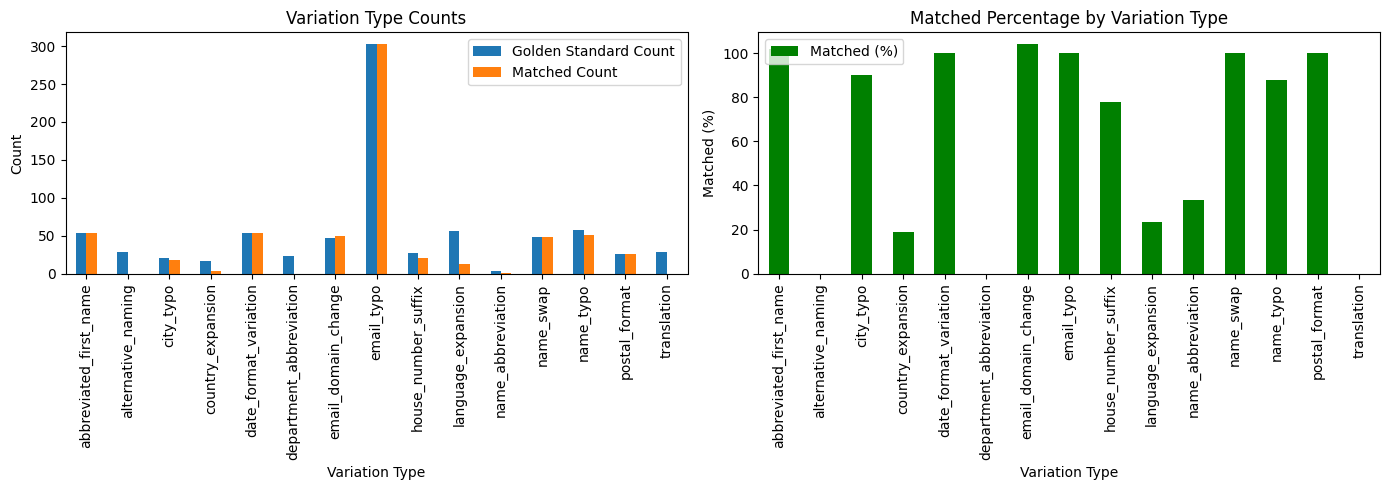

In [13]:
# ...existing code...

import matplotlib.pyplot as plt

# Bar plot for variation type comparison
variation_comparison_plot = variation_comparison.reset_index().rename(columns={'index': 'variation type'})

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Golden Standard vs Matched Count
variation_comparison_plot.plot(
    x='variation_type',
    y=['Golden Standard Count', 'Matched Count'],
    kind='bar',
    ax=ax[0]
)
ax[0].set_title('Variation Type Counts')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Variation Type')
ax[0].legend(loc='best')

# Plot Matched Percentage
variation_comparison_plot.plot(
    x='variation_type',
    y='Matched (%)',
    kind='bar',
    color='green',
    ax=ax[1]
)
ax[1].set_title('Matched Percentage by Variation Type')
ax[1].set_ylabel('Matched (%)')
ax[1].set_xlabel('Variation Type')
ax[1].legend(['Matched (%)'])

plt.tight_layout()
plt.show()
# ...existing code...